# VORTEX coronograph with POPPY
*Author: G. Orban de Xivry*
    
    
see also 

https://pythonhosted.org/poppy/index.html

and examples

https://github.com/douglase/poppy_example_notebooks/blob/master/Fresnel/Microscope_Example.ipynb

https://github.com/mperrin/poppy/blob/master/notebooks/Fresnel_Propagation_Demo.ipynb

In [1]:
%pylab inline
from poppyCoronograph import IdealAGPM
import poppy
# from poppy.poppy_core import Wavefront, _IMAGE
from poppy.poppy_core import PlaneType
import matplotlib.pyplot as plt
import astropy.units as u

N= 264
D= 10         # telescope diameter
cobs= 0.24   # central obscuration fraction
fLyot= 0.9   # Lyot stop scaling
wvl= 3.2e-6  # wavelength


''' Define of pupil apertures: Entrance pupil and Lyot stop'''
primary = poppy.CircularAperture(radius=D/2, pad_factor=4)
sec= poppy.InverseTransmission(poppy.CircularAperture(radius= D / 2 * cobs))
aperture = poppy.CompoundAnalyticOptic(name='Entrance Pupil',
                                        opticslist = [primary, sec])

lyot0= poppy.CircularAperture(radius=D / 2 * fLyot)
lyot1= poppy.SecondaryObscuration(secondary_radius=D / 2 * cobs / fLyot)
lyot= poppy.CompoundAnalyticOptic(name='Lyot pupil',
                                  opticslist = [lyot0, lyot1])

Populating the interactive namespace from numpy and matplotlib


# FFT (Fraunhofer) propagation

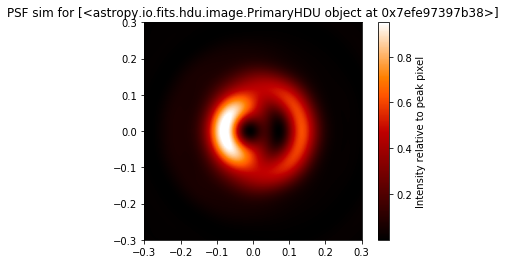

In [2]:
''' Define optical planes '''
optsys = poppy.OpticalSystem("Test", npix=N)
optsys.add_pupil(aperture)
optsys.add_image(IdealAGPM(wavelength=wvl))
optsys.add_pupil(lyot)
optsys.add_detector(pixelscale=0.001, fov_arcsec=0.6)

''' Shift on-axis source '''
optsys.source_offset_r= -0.0066    # [arcsec]
optsys.source_offset_theta= 90

''' Compute and display '''
psf = optsys.calcPSF(wavelength=wvl, display_intermediates=False)
poppy.display_PSF(psf, vmax=0.95, normalize='peak', scale='linear')

# Fresnel propagation

Implementation of a basic vortex coronagraph with only pupil and image plane and a single focal length.

Introducing aberration based on Zernike modes.

In [11]:
z= 600 * u.mm    # Focal length of optic
optsys= poppy.FresnelOpticalSystem(pupil_diameter= D * u.m,
                                   npix= N,
                                   beam_ratio=0.2)
lens1= poppy.QuadraticLens(z, 'Converging lens')

''' Defining optical planes '''
optsys.add_optic(aperture)
# Introducing Zernike aberration
zernikeCoefficients=[0, -80e-9, 0, 0, 0, 0]  # in meter wf rms
wfe= poppy.ZernikeWFE(radius= D / 2, coefficients=zernikeCoefficients)
optsys.add_optic(wfe)

optsys.add_optic(lens1, distance=z)
optsys.add_optic(IdealAGPM(wavelength=wvl), distance=z)
optsys.add_optic(lens1, distance=z)
optsys.add_optic(lyot, distance= z)
optsys.add_optic(lens1, distance=z)
optsys.add_optic(poppy.ScalarTransmission(
    planetype=PlaneType.intermediate, name="Focus"),
                 distance=z);

optsys.describe()

	Entrance pupil diam:  10.0 m	npix: 264	Beam ratio:0.2
	Pupil plane: Entrance Pupil (Analytic)
	Pupil plane: Zernike WFE (Analytic)
	Propagation distance:  0.6 m
	Lens: Quadratic Lens, with focal length 0.6 m
	Propagation distance:  0.6 m
	Image plane: unnamed AGPM  (Analytic)
	Propagation distance:  0.6 m
	Lens: Quadratic Lens, with focal length 0.6 m
	Propagation distance:  0.6 m
	Pupil plane: Lyot pupil (Analytic)
	Propagation distance:  0.6 m
	Lens: Quadratic Lens, with focal length 0.6 m
	Propagation distance:  0.6 m
	Optic: Focus


In [12]:
psf = optsys.calcPSF(wavelength=wvl, display_intermediates=False)

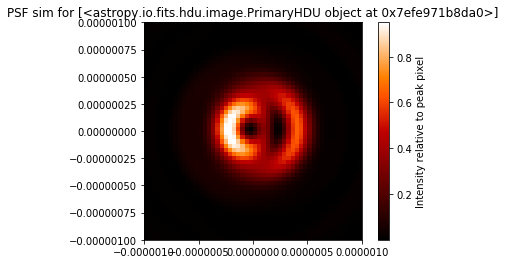

In [13]:
poppy.display_PSF(psf, vmax=0.95,
                  normalize='peak', scale='linear',
                  imagecrop=2e-6)